**Analysis owner**: Felipe Matheus <br>
**Date**: 13/04/2021 <br>
**Related JIRA issue**:  https://hurbcom.atlassian.net/browse/ML-28 and https://hurbcom.atlassian.net/browse/ML-38

This notebook objective is to model the attendants needed during each hour.

Some points to be validated during the experiments:

- If one hot encoding applied on nights and weekends make a better model
- Considering the extrapolation problem of forest like algorithms, assess the performance of neural network models

# Setup

In [1]:
import h2o
import os
import json
from h2o.automl import H2OAutoML

In [2]:
from src.DatasetLoader import DatasetLoader
from src.models.Modeling import Modeling

%load_ext autoreload
%autoreload 2

In [3]:
with open('../configurations/variables.json') as json_file:
    var = json.load(json_file)
BUCKET = var.get('BUCKET')
FOLDER = var.get('FOLDER')
MODEL_FOLDER = var.get('MODEL_FOLDER')
    
load = DatasetLoader()
modeling = Modeling()

# Loading DF from feature engineering
OBS: Considering data until April 15.

In [4]:
df = load.load_df_pickle(BUCKET, f'{FOLDER}df_to_train_apr15.pkl')

In [5]:
df

,night,weekend,chats,TMA,TME,dropout,ct_agents
time,,,,,,,
2019-06-16 00:00:00,True,True,24,11.275,19.697917,0.500000,2
2019-06-16 01:00:00,True,True,9,12.614815,9.209259,0.000000,2
2019-06-16 02:00:00,True,True,6,19.388889,0.761111,0.000000,2
2019-06-16 03:00:00,True,True,4,11.327778,0.695833,0.250000,2
2019-06-16 04:00:00,True,True,1,18.6,0.666667,0.000000,1
...,...,...,...,...,...,...,...
2021-04-15 14:00:00,False,False,383,16.676129,7.048216,0.287206,60
2021-04-15 15:00:00,False,False,444,17.952662,7.230330,0.295045,53
2021-04-15 16:00:00,False,False,336,17.442946,4.354514,0.205357,58


# Initializing H2o

In [6]:
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9xrbgyl5
  JVM stdout: /tmp/tmp9xrbgyl5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp9xrbgyl5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Whitehorse
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.4
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_1t2u1e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.863 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


# Modeling 
## Splitting
Creating splits with and without one hot 

In [7]:
X, train, test = modeling.spliting(df, 0.8, ('chats','ct_agents'))
X_one_hot, train_one_hot, test_one_hot = modeling.spliting(df, 0.8, ('night','ct_agents'))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


## Training
AML object without one hot enconding

In [10]:
aml = modeling.training(
    'attendants-allocation_2.0',
    list(df.drop(columns = 'TMA').loc[:,'chats':'ct_agents'].columns),
    "ct_agents",
    train,
    test
)

AutoML progress: |████████████████████████████████████████████████████████| 100%


AML object with one hot encoding

In [9]:
aml_one_hot = modeling.training(
    'att_all_one_hot-v1.0',
     list(df.drop(columns = 'TMA').loc[:,'night':'ct_agents'].columns),
     "ct_agents",
     train_one_hot,
     test_one_hot
)

AutoML progress: |████████████████████████████████████████████████████████| 100%


## Explanation 
This explanation aims to focus on 3 aspects:
- Leaderboard
    To compare the performance of each model following the traditional metrics (RMSE, MAE)
- Variable importance
    To provide insights to the stakeholders about the feature importance.
    OBS: In this case it shows for the best model (unconsidering StackedEnsemble)
- Variable importance heatmap
    To provide the weights of each model considering the features. So we can choose the one that relies less on the chats, once it is the most uncertain value.

# Without one hot encoding

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_AutoML_20210726_105018,41.1816,6.41729,41.1816,4.0212,nan,320,0.020252,StackedEnsemble
StackedEnsemble_BestOfFamily_AutoML_20210726_105018,41.4097,6.43503,41.4097,4.01216,nan,407,0.013691,StackedEnsemble
GBM_2_AutoML_20210726_105018,42.219,6.49762,42.219,4.08552,nan,160,0.010466,GBM
GBM_1_AutoML_20210726_105018,42.3825,6.51019,42.3825,4.12466,nan,154,0.009612,GBM
GBM_grid__1_AutoML_20210726_105018_model_1,43.008,6.55805,43.008,4.17831,nan,176,0.012362,GBM
XGBoost_grid__1_AutoML_20210726_105018_model_4,43.3284,6.58243,43.3284,4.10881,nan,206,0.001302,XGBoost
XGBoost_grid__1_AutoML_20210726_105018_model_3,43.5,6.59545,43.5,4.17098,nan,220,0.00212,XGBoost
GBM_3_AutoML_20210726_105018,43.805,6.61853,43.805,4.20571,nan,186,0.012866,GBM
GBM_5_AutoML_20210726_105018,43.9009,6.62577,43.9009,4.26134,nan,288,0.018147,GBM
GBM_4_AutoML_20210726_105018,43.9296,6.62794,43.9296,4.20946,nan,193,0.0121,GBM


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

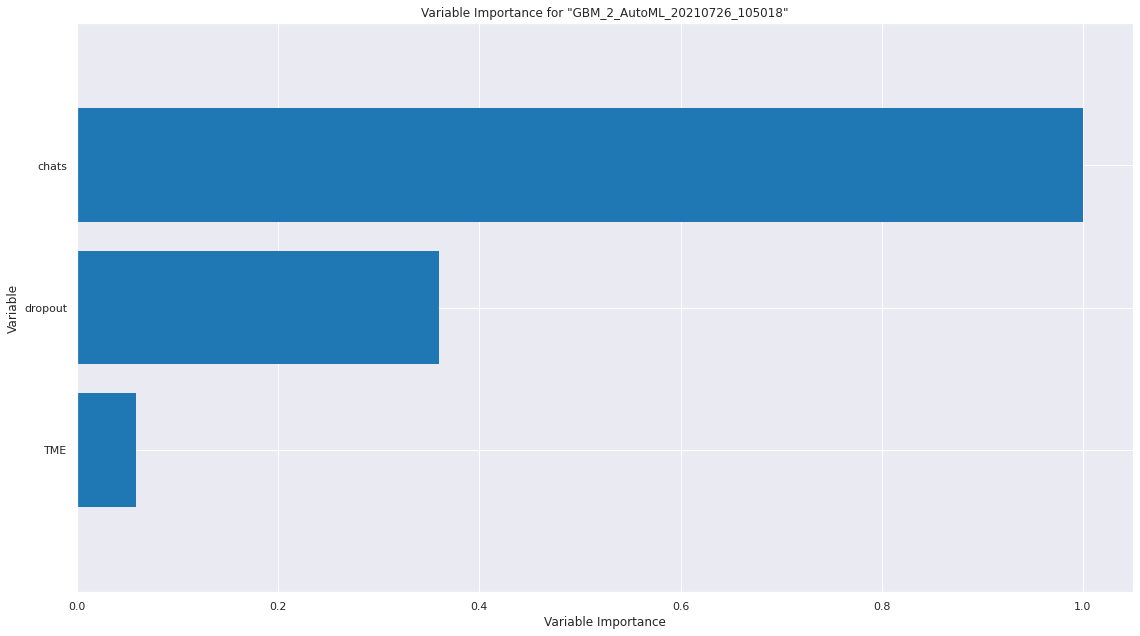

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

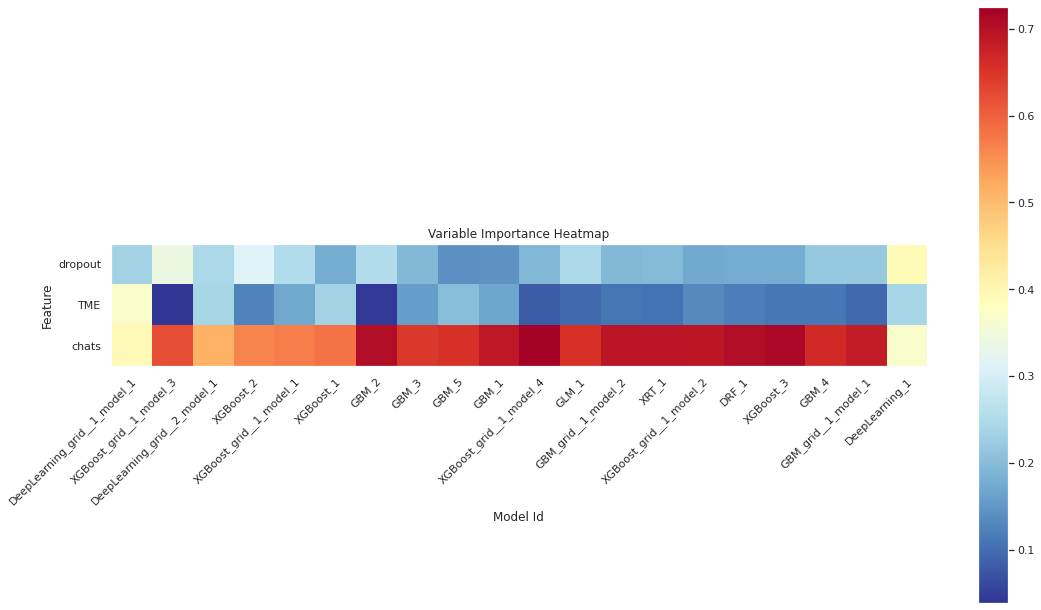

In [11]:
try:
    (aml.explain(test, include_explanations=["varimp_heatmap", "varimp", "leaderboard"]))[0]
except KeyError:
    pass

# With one hot encoding

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20210716_081359,38.6811,6.21942,38.6811,3.84534,nan,386,0.030757
StackedEnsemble_BestOfFamily_AutoML_20210716_081359,38.8448,6.23256,38.8448,3.85467,nan,244,0.010215
GBM_1_AutoML_20210716_081359,39.0902,6.25221,39.0902,3.86723,0.329067,176,0.009707
GBM_2_AutoML_20210716_081359,39.5424,6.28827,39.5424,3.89932,nan,183,0.012856
GBM_3_AutoML_20210716_081359,40.4776,6.3622,40.4776,3.93172,0.330271,191,0.012462
GBM_5_AutoML_20210716_081359,40.5131,6.36499,40.5131,3.96935,nan,271,0.016141
XGBoost_grid__1_AutoML_20210716_081359_model_4,40.594,6.37134,40.594,3.98778,nan,162,0.001828
GBM_grid__1_AutoML_20210716_081359_model_1,40.6194,6.37334,40.6194,4.02571,nan,266,0.023891
XGBoost_grid__1_AutoML_20210716_081359_model_3,41.5077,6.44265,41.5077,4.06643,nan,325,0.002715
GBM_4_AutoML_20210716_081359,41.8525,6.46935,41.8525,4.02184,nan,257,0.014898


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

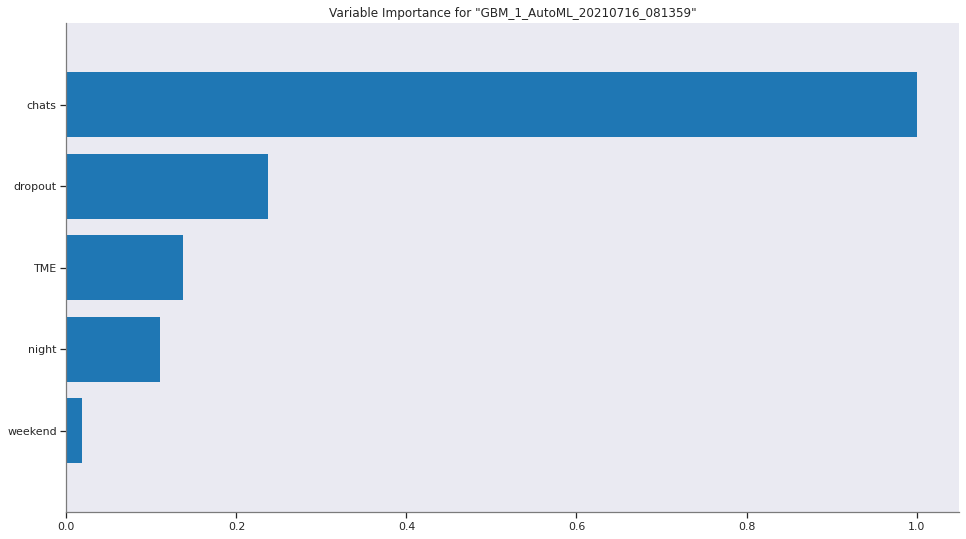

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

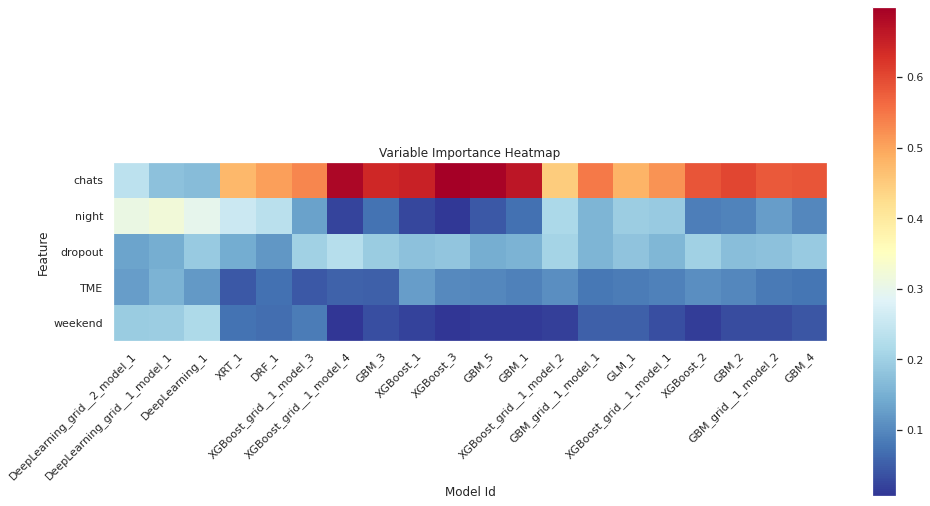

In [27]:
try:
    (aml_one_hot.explain(test_one_hot, include_explanations=["varimp_heatmap", "varimp", "leaderboard"]))[0]
except KeyError:
    pass

# Conclusions:
So far we can conclude:
- The best models are fores like models. However, we won't be using those models due to the following points:
    - They heavily consider the amount of inputted chats, and it is our most non reliable feature.
    - They suffer from the extrapolation problem. If we ever need to predict an amount of attendants higher than the highest value already allocated, the model won't be able to provide that value. (It was tested during the tests with stakeholders).
- Deep Learning models are the best non forest like algorithms. Also they rely less on chats, therefore, we will use DL models.
- The performance of DL models weren't low despite lower than the others. Difference of 13% (6.40508/7.34417) of precision only.
- Model considering non hot encodings performed better.

As a final assessment we will just analyze how feature importance is distributed over DL model:

In [13]:
model = h2o.get_model('DeepLearning_1_AutoML_20210726_105018')

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

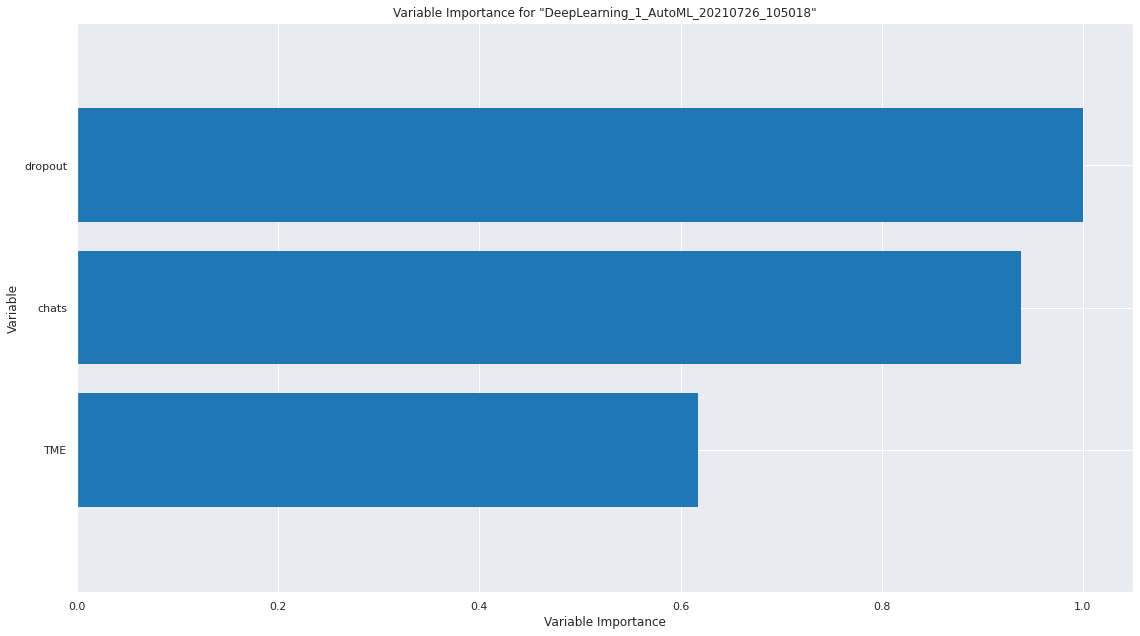

In [14]:
try:
    model.explain(test, include_explanations=["varimp"])
except KeyError:
    pass

# Saving DL model on GCP

## Mojo

In [15]:
model.save_mojo(f'gs://{BUCKET}/{MODEL_FOLDER}')

'gs://hurb_internal_dsc_files/models/attendants-allocation/DeepLearning_1_AutoML_20210726_105018.zip'

## Binary

In [17]:
h2o.save_model(model=model, path=f'gs://{BUCKET}/{MODEL_FOLDER}')

'gs://hurb_internal_dsc_files/models/attendants-allocation/DeepLearning_1_AutoML_20210726_105018'